In [21]:
from typing import Annotated
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict
from langchain_core.tools import Tool
from langchain.tools import tool
from langchain_core.messages import BaseMessage
from langchain_openai import AzureChatOpenAI
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper 
from IPython.display import Image
import os 
from dotenv import load_dotenv
load_dotenv()

os.environ['AZURE_OPENAI_API_KEY'] = os.getenv('AZURE_OPENAI_API_KEY')
AZURE_API_ENDPOINT = os.getenv('AZURE_API_ENDPOINT')
AZURE_DEPLOYMENT_NAME = os.getenv('AZURE_DEPLOYMENT_NAME')
AZURE_API_VERSION = os.getenv('AZURE_API_VERSION')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'ReAct-Agent_v2'

In [6]:
llm = AzureChatOpenAI(
    model='gpt-4.1-mini',
    azure_endpoint=AZURE_API_ENDPOINT,
    deployment_name=AZURE_DEPLOYMENT_NAME,
    api_version=AZURE_API_VERSION
)

In [4]:
class State(TypedDict):
    topic: str
    characters: str 
    settings: str
    premises: str
    story_intro: str  

In [6]:
def generate_characters(state:State):
    message = llm.invoke(f'create two character names and brief traits for a story about {state["topic"]}')
    return {"characters": message.content}

def generate_settings(state:State):
    message = llm.invoke(f'Describe a vivid settings for a story about {state["topic"]}')
    return {"settings": message.content}
    
def generate_premises(state:State):
    message = llm.invoke(f'Write a one-sentence plat premise for a story about {state["topic"]}')
    return {"premises":message.content}

def generate_story_intro(state:State):
    message = llm.invoke(
        "Write a short story introduction using the elements:\n"
        f"Characters: {state['characters']}"
        f"Characters: {state['characters']}"
        f"Characters: {state['characters']}"
    )
    return {'story_intro': message.content}

In [9]:
graph = StateGraph(State)

graph.add_node('generate_characters', generate_characters)
graph.add_node('generate_settings', generate_settings)
graph.add_node('generate_premises', generate_premises)
graph.add_node('generate_story_intro', generate_story_intro)

graph.add_edge(START, 'generate_characters')
graph.add_edge(START, 'generate_settings')
graph.add_edge(START, 'generate_premises')
graph.add_edge('generate_characters', 'generate_story_intro')
graph.add_edge('generate_settings', 'generate_story_intro')
graph.add_edge('generate_premises', 'generate_story_intro')
graph.add_edge("generate_story_intro", END)

In [32]:
graph_image = graph.compile()
display(Image(graph_image.get_graph().draw_mermaid_png()))

AttributeError: 'CompiledStateGraph' object has no attribute 'compile'

In [13]:
result = graph_image.invoke({"topic": "Time Travel"})

In [14]:
print(result['story_intro'])

Elara Voss stood alone in the dim glow of her lab, the hum of quantum processors filling the air like a distant heartbeat. Her fingers trembled as she traced the edge of the silver locket resting against her chest—a delicate, unassuming heirloom that held a secret few could understand. Inside it, etched with microscopic precision, was the key to bending time itself, a riddle left by the mother she lost too soon.

Tonight, the fractures in her world felt sharper than ever. The equations she’d spent years perfecting whispered of possibilities and peril, of a chance to rewrite tragedy without unraveling the fragile thread of reality.

The door creaked open behind her, and a shadow stepped in—Jaxon Cade, a man whose very presence seemed to shift the atmosphere. Charismatic but worn, his rogue timepiece ticked softly beneath his worn leather jacket, counting down moments only he could command.

“Elara,” he said with a wry smile that barely hid the weight of his past. “Time’s not waiting for

In [3]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, AIMessage, SystemMessage, HumanMessage

In [4]:
class Route(BaseModel):
    step:Literal["poem", "story", "joke"]=Field(description="The next step in the routing process")

In [7]:
router = llm.with_structured_output(Route)

In [8]:
class State(TypedDict):
    input:str
    decision:str
    output:str

In [25]:
def llm_call_1(state:State):
    "Write a story"
    result = llm.invoke(state['input'])
    return {'output': result.content}

def llm_call_2(state:State):
    "Write a joke"
    result = llm.invoke(state['input'])
    return {'output': result.content}

def llm_call_3(state:State):
    "Write a poem"
    result = llm.invoke(state['input'])
    return {'output': result.content}

def llm_call_router(state:State):
    """Route the input to the appropriate node"""
    
    decision = router.invoke(
        [
            SystemMessage(content="Route the input to story, joke or poem based on the users request"),
            HumanMessage(content=state['input'])
        ]
    )
    
    return {"decision": decision.step}

In [26]:
def route_decision(state:State):
    if state['decision'] == 'story':
        return 'llm_call_1'
    elif state['decision'] == 'joke':
        return 'llm_call_2'
    elif state['decision'] == 'poem':
        return 'llm_call_3'

In [27]:
builder = StateGraph(State)
builder.add_node("llm_call_router", llm_call_router)
builder.add_node('llm_call_1', llm_call_1)
builder.add_node('llm_call_2', llm_call_2)
builder.add_node('llm_call_3', llm_call_3)


builder.add_edge(START, 'llm_call_router')
builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3"
    }
)
builder.add_edge('llm_call_1', END)
builder.add_edge('llm_call_2', END)
builder.add_edge('llm_call_3', END)


In [28]:
router_workflow = builder.compile()

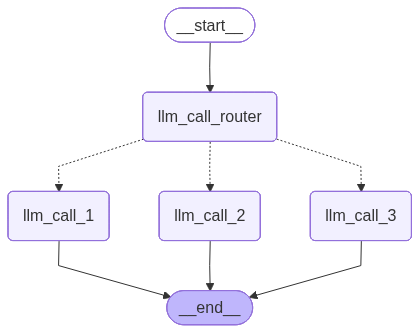

In [29]:
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [30]:
state = router_workflow.invoke({"input": "Write me a joke about agentic AI system"})

In [31]:
state

{'input': 'Write me a joke about agentic AI system',
 'decision': 'joke',
 'output': 'Why did the agentic AI bring a briefcase to the server room?\n\nBecause it heard it needed to take some “initiative” in processing!'}